

# Attrition Part 1
# Data Ingestion and Modeling with Python and PostgreSQL
   <font size="3">Author: Amogh Rao</font>

## Contents

1. Introduction and Business Context
2. Data Ingestion
3. Conceptual Schema Design
4. Data Modeling
5. Data Loading and Further Considerations

## Introduction and Business Context

The purpose of this project is to emulate a People Analytics SaaS company that provides analytics solutions to businesses focused on their people and workforce. 

Typically, a client would provide us with preliminary sample data, which we would ingest, transform and load into our pre-designed database. Once the data and metrics are prepared according to our design, we build the MVP and showcase its impact to the client so we can establish a contract. In this situation, our client is IBM and their business problem is involuntary turnover.

In part one of this project, I will be ingesting IBM's data from their server (in this case Kaggle), modeling the data according to our design, and finally loading it into our server (in this case a personal Postgres server).

In the second part of this project we will explore IBM's data, perform our analyses and design our supervised learning model that will predict involuntary turnover. This is the solution that we would present to IBM as our MVP in the form of a dynamic report using a BI Tool (in this case Tableau).

Questions we would like to explore -
 
1. What kinds of attrition (regrettable, new hire) are we facing and how concerning are they given industry benchmarks?
2. Which departments and job roles are most at-risk?
3. What are the statistically significant drivers of attrition based on our pre-defined metrics?
4. What is every employee's risk of exit (Probability of Attrition)?

## Setup and Data Ingestion

Usually this step would be much more complicated, but since we are dealing with just a sample of the client's data and I don't have access to high-end cloud infrastructure, I will use a simple Kaggle API to request our data directly from their website.

**Load Necessary Libraries**

In [3]:
#Data Wrangling

import pandas as pd
import numpy as np

#Data Modeling and DB Design

import os
import psycopg2
from dotenv import load_dotenv

#Data Loading

import psycopg2.extras 
from psycopg2.extensions import register_adapter, AsIs
psycopg2.extensions.register_adapter(np.int64, psycopg2._psycopg.AsIs)

**Ingest Client Data**

In [9]:
pip install kaggle
!kaggle datasets download -d pavansubhasht/ibm-hr-analytics-attrition-dataset

ibm-hr-analytics-attrition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [1]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [3]:
# Explore the different features

print(df.columns.values)
df.head(5)

['Age' 'Attrition' 'BusinessTravel' 'DailyRate' 'Department'
 'DistanceFromHome' 'Education' 'EducationField' 'EmployeeCount'
 'EmployeeNumber' 'EnvironmentSatisfaction' 'Gender' 'HourlyRate'
 'JobInvolvement' 'JobLevel' 'JobRole' 'JobSatisfaction' 'MaritalStatus'
 'MonthlyIncome' 'MonthlyRate' 'NumCompaniesWorked' 'Over18' 'OverTime'
 'PercentSalaryHike' 'PerformanceRating' 'RelationshipSatisfaction'
 'StandardHours' 'StockOptionLevel' 'TotalWorkingYears'
 'TrainingTimesLastYear' 'WorkLifeBalance' 'YearsAtCompany'
 'YearsInCurrentRole' 'YearsSinceLastPromotion' 'YearsWithCurrManager']


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Conceptual Schema Design

Despite having a clean and structured dataset ready for analysis, I would like to build a database schema since the purpose of this project is to emulate a solution. Usually, client data isnt ingested as a single flat table since there would be far too many variables to make this efficient. Hence, I decided to pick a star schema structure since it isn't normalized to a level that hinders analysis, but is also structured and easy to query independently.

When building a database, I personally like designing the schema based on the business problem and questions we would like to ask in order to reach the solution. Once we have highlighted the metrics we want to analyze, we model our tables in order to create the best fit logical structure to guide our analyses of these metrics. This means we would like to query information from this database in as easy and structured a manner as possible. 

Another reason for this is that very often companies use different people softwares for different tasks. One might use Workday as a primary HRIS, UKG for capacity planning, iCIMS as an ATS and Visier for integrated analytics. Hence, this database design would help reflect the different data sources which may have to be ingested independently.

Our star schema fact will revolve around the business question, while the dimensions will give us additional information about metrics that might bring us closer to the solution.

**Organizational Identity Fact**

Employee Number, Attrition

**Function Metrics**

Department, Job Role, Job Level


**Performance Metrics**

Performance Rating, Years Since Last Promotion, Years In Current Role, Training Times Since Last Year


**Compensation Metrics**

Daily Rate, Monthy Income, Monthly Rate, Overtime, Salary Hike, Stock Option Level 


**Engagement Metrics**

Business Travel, Environment Satisfaction, Job Involvement, Job Satisfaction, Relationship Satisfaction, Years with Current Manager, Work Life Balance


**Personal Metrics**

Age, Distance from Home, Education, Education Field, Gender, Marital Status, Number of Companies Worked, Total Working Years


<mark>Note: Employee Number will be a primary key in the fact table and all other tables will reference it.</mark>

# Data Modeling -  Logical Design

Now we're ready to build the schema into our database and load the data into their respective tables. I am building a customizable workflow that can be triggered as needed, under the assumption that this is not a one-time task, and we will be using this schema design for other clients apart from IBM. 

Process

1. Create query strings for schema design, fact table design and dimension designs 
2. Queue up query strings and run them in order
3. Load values into every table

In [4]:
conString = {'host':'localhost',
             'dbname':'ibmattrition',
             'user':'postgres',
             'password':'petproject',
             'port':5432}

print(conString)
conn = psycopg2.connect(**conString)
cur = conn.cursor()

{'host': 'localhost', 'dbname': 'ibmattrition', 'user': 'postgres', 'password': 'petproject', 'port': 5432}


In [62]:
#conn.close()
#conn.rollback()

schema = """ CREATE SCHEMA IF NOT EXISTS churn"""

tables = """
CREATE TABLE IF NOT EXISTS churn.orgid (
    employeeid int PRIMARY KEY,
    attrition text CHECK (attrition IN ('Yes', 'No'))
);
    
CREATE TABLE IF NOT EXISTS churn.function (
    employeeid int REFERENCES churn.orgid(employeeid),
    department text NOT NULL,
    jobrole text NOT NULL,
    joblevel int CHECK (joblevel BETWEEN 1 AND 5)
    );
    
CREATE TABLE IF NOT EXISTS churn.performance (
    employeeid int REFERENCES churn.orgid(employeeid),
    performancerating int CHECK (performancerating BETWEEN 1 AND 4),
    lastpromotion int NOT NULL,
    currentrole int NOT NULL,
    trainings int NOT NULL
    );
    
CREATE TABLE IF NOT EXISTS churn.compensation (
    employeeid int REFERENCES churn.orgid(employeeid),
    dailyrate numeric NOT NULL,
    income numeric NOT NULL,
    overtime text CHECK (overtime IN ('Yes', 'No')),
    salaryhike numeric,
    stockoption int CHECK (stockoption BETWEEN 0 AND 3)
    );   
    
CREATE TABLE IF NOT EXISTS churn.engagement (
    employeeid int REFERENCES churn.orgid(employeeid),
    travel text,
    envsat int CHECK (envsat BETWEEN 1 AND 4),
    involvement int CHECK (involvement BETWEEN 1 AND 4),
    jobsat int CHECK (jobsat BETWEEN 1 AND 4),
    relationsat int CHECK (relationsat BETWEEN 1 AND 4),
    yearswithmanager int NOT NULL,
    worklifebal int CHECK (worklifebal BETWEEN 1 AND 4)
    );
    
CREATE TABLE IF NOT EXISTS churn.personal (
    employeeid int REFERENCES churn.orgid(employeeid),
    age int NOT NULL,
    distfromhome int CHECK (distfromhome > 0),
    education int NOT NULL,
    educationfield text NOT NULL,
    gender text,
    maritalstatus text,
    previouscompanies int,
    totalexp int NOT NULL
    );
    
"""

In [36]:
cur.execute(schema)
conn.commit()

In [61]:
cur.execute(tables)
conn.commit()

**Our schema is now ready**

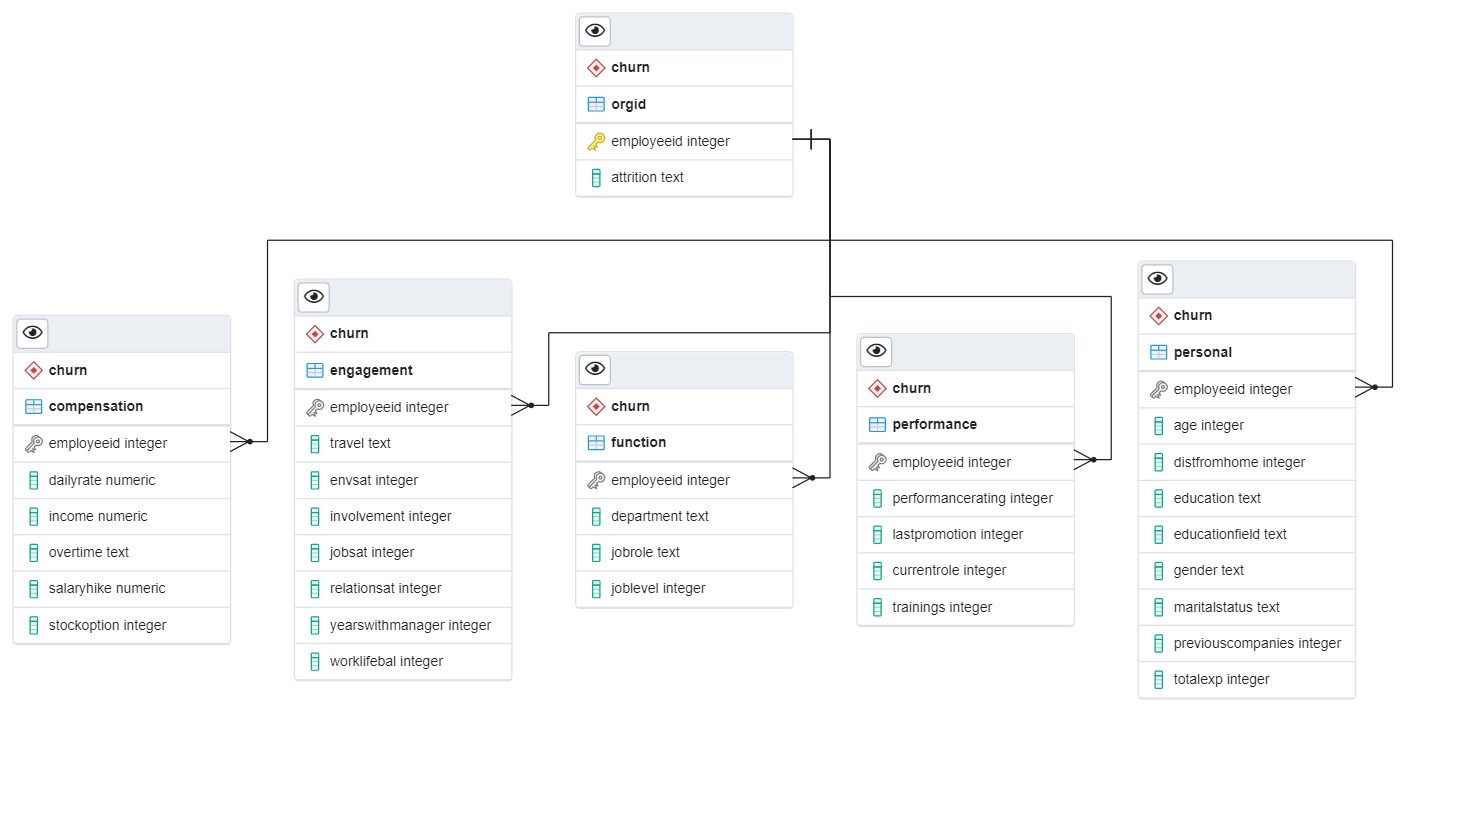

## Loading Data into Postgres

We can now load our client's data into our database schema using insert commands. I am using individual code blocks for each step in the loading process so I can make changes to the script as needed in the future. Using execute_batch is horribly inefficient for larger volumes of data, so in those situations I would switch to something like copy_from.

This might be a one-time project, but if I were building a reproducable workflow for multiple ingestions I'd probably do the following:

- Create each table definition as a standalone SQL script file based on the data model
- Create an ingestion script in python that loads the data into objects or dataframes
- Create a script with all the necessary transformations using user-defined functions
- Create a main ETL script that runs the SQL table scripts in a pre-defined order to design the necessary schema, runs the ingestion and transformation scripts, and finally runs sequential copy_from functions that load the data into our schema

In [73]:
# Extract relevant columns for each table
identity = df[['EmployeeNumber', 'Attrition']]
function = df[['EmployeeNumber','Department', 'JobRole', 'JobLevel']]
performance = df[['EmployeeNumber', 'PerformanceRating', 'YearsSinceLastPromotion', 'YearsInCurrentRole', 'TrainingTimesLastYear']]
engagement = df[['EmployeeNumber', 'BusinessTravel', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'RelationshipSatisfaction', 'YearsWithCurrManager', 'WorkLifeBalance']]
compensation = df[['EmployeeNumber', 'DailyRate', 'MonthlyIncome', 'OverTime', 'PercentSalaryHike', 'StockOptionLevel']]
personal = df[['EmployeeNumber', 'Age', 'DistanceFromHome', 'Education', 'EducationField', 'Gender', 'MaritalStatus', 'NumCompaniesWorked', 'TotalWorkingYears']]

# Convert dataframes to tuples for loading
idtuple = [tuple(i) for i in identity.to_numpy()]
functuple = [tuple(f) for f in function.to_numpy()]
perftuple = [tuple(p) for p in performance.to_numpy()]
engtuple = [tuple(e) for  in engagement.to_numpy()]
comptuple = [tuple(c) for c in compensation.to_numpy()]
perstuple = [tuple(p) for p in personal.to_numpy()]

In [ ]:
psycopg2.extras.execute_batch(cur, """INSERT INTO churn.orgid 
                        (employeeid, attrition) 
                    VALUES (%s, %s)""", idtuple)
conn.commit()

In [76]:
psycopg2.extras.execute_batch(cur, """INSERT INTO churn.function 
                        (employeeid, department, jobrole, joblevel) 
                    VALUES (%s, %s, %s, %s)""", functuple)
conn.commit()

In [80]:
psycopg2.extras.execute_batch(cur, """INSERT INTO churn.performance 
                        (employeeid, performancerating, lastpromotion, currentrole, trainings) 
                    VALUES (%s, %s, %s, %s, %s)""", perftuple)
conn.commit()

In [81]:
psycopg2.extras.execute_batch(cur, """INSERT INTO churn.engagement 
                        (employeeid, travel, envsat, involvement, jobsat, relationsat, yearswithmanager, worklifebal) 
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)""", engtuple)
conn.commit()

In [82]:
psycopg2.extras.execute_batch(cur, """INSERT INTO churn.compensation 
                        (employeeid, dailyrate, income, overtime, salaryhike, stockoption) 
                    VALUES (%s, %s, %s, %s, %s, %s)""", comptuple)
conn.commit()

In [83]:
psycopg2.extras.execute_batch(cur, """INSERT INTO churn.personal 
                        (employeeid, age, distfromhome, education, educationfield, 
                        gender, maritalstatus, previouscompanies, totalexp) 
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)""", perstuple)
conn.commit()



**The data is now loaded!**

Let's run a quick query to test our database. We can try to answer one of our business questions, which is - "Which departments are most at-risk?"

In [10]:
businessq = """

with cte as (select sum(case
            when o.attrition = 'Yes' then 1
            when o.attrition = 'No' then 0 end) as total_attrition ,count(f.employeeid) as no_of_employees, f.department
from churn.orgid o
join churn.function f using (employeeid)
group by f.department)

select department, total_attrition, no_of_employees, round((total_attrition*100.00/no_of_employees), 2) as attrition_rate
from cte;

"""
#I'm sure this is far from an efficient query, but I thought a CTE would make things more readable

cur.execute(businessq)
churntable = pd.DataFrame(cur.fetchall(), columns = ['department', 'total_attrition', 'no_of_employees', 'attrition_rate'])
churntable.head()

,department,total_attrition,no_of_employees,attrition_rate
0,Human Resources,12,63,19.05
1,Research & Development,133,961,13.84
2,Sales,92,446,20.63


Given an <a href="https://www.linkedin.com/business/learning/blog/learner-engagement/see-the-industries-with-the-highest-turnover-and-why-it-s-so-hi" target="_blank">industry benchmark of 13.2% attrition</a>, we'd probably want to be a bit concerned about IBM's HR and Sales functions. 

## Further Considerations

Now that our data has been ingested, we can move into the analytics part of this project. This whole process of splitting up the dataset only to join it later might seem redundant, but the purpose of this project is for me to play around with my fundamentals and try to apply real world considerations to the stuff I've learned in academia. This dataset was already super structured and clean, so it wasn't a challenge in any way. However, it's fun to try and emulate a real-life workflow and blend SQL, Python, R and Tableau all together.

I felt more comfortable doing the database design in Python, but I'll be moving to R for the next bit since it's hands down the most extensive and fun language for all things stats. Consequently, I'll be running my dashboards on Tableau's public server and embedding my predictive model built in R, directly into Tableau. Thanks for sticking around and see you in Part 2!